In [1]:
import numpy as np
import torch
import torchvision.transforms as T
import torch.nn.functional as F
from PIL import Image
from scipy.spatial.distance import mahalanobis
from models import build_model
from util.misc import NestedTensor
from torch.utils.data import DataLoader
import datasets.samplers as samplers
import util.misc as utils
import matplotlib.pyplot as plt
from datasets.torchvision_datasets.open_world import OWDetection
from datasets.coco import make_coco_transforms

from args import Args

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

import tqdm
import os

{'OWDETR': ('aeroplane', 'bicycle', 'bird', 'boat', 'bus', 'car', 'cat', 'cow', 'dog', 'horse', 'motorbike', 'sheep', 'train', 'elephant', 'bear', 'zebra', 'giraffe', 'truck', 'person', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'chair', 'diningtable', 'pottedplant', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'bed', 'toilet', 'sofa', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'tvmonitor', 'bottle', 'unknown'), 'TOWOD': ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args()

# 모델과 postprocessor 준비
model, _, postprocessors, exemplar_selection = build_model(args, mode=args.model_type)
model.to(device)

Invalid class range: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
DINO resnet50


/home/yongho/miniconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/yongho/miniconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


running with exemplar_replay_selection


DeformableDETR(
  (transformer): DeformableTransformer(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affin

In [3]:
def get_datasets(args):
    print(args.dataset)

    train_set = args.train_set
    test_set = args.test_set
    dataset_train = OWDetection(args, args.data_root, image_set=args.train_set, transforms=make_coco_transforms(args.train_set), dataset = args.dataset)
    dataset_val = OWDetection(args, args.data_root, image_set=args.test_set, dataset = args.dataset, transforms=make_coco_transforms(args.test_set))

    print(args.train_set)
    print(args.test_set)
    print(dataset_train)
    print(dataset_val)

    return dataset_train, dataset_val

def preprocess_image(image_path, device):
    """
    쿼리 이미지 전처리 함수: 모델이 요구하는 입력 형식으로 변환
    """
    image = Image.open(image_path).convert('RGB')
    w, h = image.size

    transform = T.Compose([
        T.Resize((800, 800)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img_tensor = transform(image).unsqueeze(0).to(device)  # (1, C, H, W)
    return NestedTensor(img_tensor, torch.zeros_like(img_tensor[:, 0]))  # NestedTensor 변환

# Feature Representation 추출
def extract_encoder_features(model, features, pos, masks, samples):
    """
    Backbone을 통과한 Feature Map을 Transformer Encoder 입력 형식으로 변환
    """
    srcs, masks = [], []
    for l, feat in enumerate(features):
        src, mask = feat.decompose()
        srcs.append(model.input_proj[l](src))
        masks.append(mask)

    if model.num_feature_levels > len(srcs):
        _len_srcs = len(srcs)
        for l in range(_len_srcs, model.num_feature_levels):
            if l == _len_srcs:
                src = model.input_proj[l](features[-1].tensors)
            else:
                src = model.input_proj[l](srcs[-1])
            m = samples.mask
            mask = F.interpolate(m[None].float(), size=src.shape[-2:]).to(torch.bool)[0]
            pos_l = model.backbone[1](NestedTensor(src, mask)).to(src.dtype)
            srcs.append(src)
            masks.append(mask)
            pos.append(pos_l)

    # Feature Map 크기 변환
    src_flatten, mask_flatten, lvl_pos_embed_flatten, spatial_shapes = [], [], [], []
    for lvl, (src, mask) in enumerate(zip(srcs, masks)):
        bs, c, h, w = src.shape
        print(src.shape)
        spatial_shapes.append((h, w))
        src = src.flatten(2).transpose(1, 2)
        mask = mask.flatten(1)
        lvl_pos_embed = model.transformer.level_embed[lvl].unsqueeze(0).repeat(1, src.shape[1], 1)
        lvl_pos_embed_flatten.append(lvl_pos_embed)
        src_flatten.append(src)
        mask_flatten.append(mask)

    src_flatten = torch.cat(src_flatten, 1)
    mask_flatten = torch.cat(mask_flatten, 1)
    lvl_pos_embed_flatten = torch.cat(lvl_pos_embed_flatten, 1)
    spatial_shapes = torch.as_tensor(spatial_shapes, dtype=torch.long, device=src_flatten.device)
    level_start_index = torch.cat((spatial_shapes.new_zeros((1,)), spatial_shapes.prod(1).cumsum(0)[:-1]))
    valid_ratios = torch.stack([model.transformer.get_valid_ratio(m) for m in masks], 1)

    # encoder
    memory = model.transformer.encoder(src_flatten, spatial_shapes, level_start_index, valid_ratios, lvl_pos_embed_flatten, mask_flatten)

    return memory, spatial_shapes, level_start_index, valid_ratios, mask_flatten

# Query Embedding 추출
def extract_decoder_embedding(model, memory, spatial_shapes, level_start_index, valid_ratios, mask_flatten):
    """
    Backbone을 통과한 Feature Map을 Transformer Encoder 입력 형식으로 변환
    """
    query_embed = model.query_embed.weight
    # prepare input for decoder
    bs, _, c = memory.shape
    if model.two_stage:
        output_memory, output_proposals = model.gen_encoder_output_proposals(memory, mask_flatten, spatial_shapes)

        # hack implementation for two-stage Deformable DETR
        enc_outputs_class = model.decoder.class_embed[model.decoder.num_layers](output_memory)
        enc_outputs_coord_unact = model.decoder.bbox_embed[model.decoder.num_layers](output_memory) + output_proposals

        topk = model.two_stage_num_proposals
        topk_proposals = torch.topk(enc_outputs_class[..., 0], topk, dim=1)[1] ##TODO?? Why only based on first dimension??
        topk_coords_unact = torch.gather(enc_outputs_coord_unact, 1, topk_proposals.unsqueeze(-1).repeat(1, 1, 4))
        topk_coords_unact = topk_coords_unact.detach()
        reference_points = topk_coords_unact.sigmoid()
        init_reference_out = reference_points
        pos_trans_out = model.pos_trans_norm(model.pos_trans(model.get_proposal_pos_embed(topk_coords_unact)))
        query_embed, tgt = torch.split(pos_trans_out, c, dim=2)
    else:
        query_embed, tgt = torch.split(query_embed, c, dim=1)
        query_embed = query_embed.unsqueeze(0).expand(bs, -1, -1)
        tgt = tgt.unsqueeze(0).expand(bs, -1, -1)
        reference_points = model.transformer.reference_points(query_embed).sigmoid()
        init_reference_out = reference_points

    # decoder
    hs, inter_references = model.transformer.decoder(tgt, reference_points, memory, spatial_shapes, level_start_index, valid_ratios, query_embed, mask_flatten)

    inter_references_out = inter_references

    if model.two_stage:
        return hs, init_reference_out, inter_references_out, enc_outputs_class, enc_outputs_coord_unact

    #return hs, init_reference_out, inter_references_out, None, None
    return hs[-1].cpu().detach().numpy()

# 데이터 저장 함수 (Batch 단위 Append)
def append_to_file(file_path, data):
    """
    기존 npz 파일에 데이터를 추가 저장하는 함수
    """
    if os.path.exists(file_path):
        existing_data = np.load(file_path)
        new_data = np.concatenate([existing_data["arr_0"], data], axis=0)
    else:
        new_data = data
    np.savez_compressed(file_path, new_data)

def visualize_features(encoder_features, decoder_features, encoder_y, decoder_y, method="tsne"):
    """
    Transformer Encoder 및 Decoder Feature를 차원 축소 후 시각화
    """
    if method == "pca":
        reducer = PCA(n_components=2)
    else:
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)

    # Encoder와 Decoder Feature 각각 변환
    encoder_2d = reducer.fit_transform(encoder_features)
    decoder_2d = reducer.fit_transform(decoder_features)

    # 시각화
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Encoder Feature 시각화
    sns.scatterplot(x=encoder_2d[:, 0], y=encoder_2d[:, 1], hue=encoder_y, palette="viridis", alpha=0.8, edgecolor="k", ax=ax[0])
    ax[0].set_title(f"Transformer Encoder Feature ({method.upper()})")
    ax[0].set_xlabel(f"{method.upper()} Component 1")
    ax[0].set_ylabel(f"{method.upper()} Component 2")

    # Decoder Feature 시각화
    sns.scatterplot(x=decoder_2d[:, 0], y=decoder_2d[:, 1], hue=decoder_y, palette="coolwarm", alpha=0.8, edgecolor="k", ax=ax[1])
    ax[1].set_title(f"Transformer Decoder Feature ({method.upper()})")
    ax[1].set_xlabel(f"{method.upper()} Component 1")
    ax[1].set_ylabel(f"{method.upper()} Component 2")

    plt.legend(title="Class Labels")
    plt.tight_layout()
    plt.show()


In [4]:
# 모델 로드 및 실행 예제
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("./exps/MOWODB/PROB/t1/checkpoint0040.pth", map_location=device)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

DeformableDETR(
  (transformer): DeformableTransformer(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affin

In [5]:
dataset_train, dataset_val = get_datasets(args)

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, args.batch_size, drop_last=True)
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)

TOWOD
owod_t1_train
owod_all_task_test
Dataset OWDetection
    Number of datapoints: 16551
    Root location: ./data/OWOD
    [['train'], Compose(
    Compose(
)
)]
Dataset OWDetection
    Number of datapoints: 10246
    Root location: ./data/OWOD
    [['test'], Compose(
    Compose(
)
)]


In [12]:
# 이미지 전처리 및 NestedTensor 변환
nested_tensor = preprocess_image("test_img/image.png", device)

# Backbone에서 Feature Map 추출
with torch.no_grad():
    features, pos = model.backbone(nested_tensor)

# Encoder 입력 준비
masks = [torch.zeros_like(f.tensors[:, 0], dtype=torch.bool) for f in features]

In [13]:
outputs = model(nested_tensor)

In [14]:
temperature = args.obj_temp/args.hidden_dim
invalid_cls_logits = list(range(args.PREV_INTRODUCED_CLS+args.CUR_INTRODUCED_CLS, args.num_classes-1))
out_logits, pred_obj = outputs['pred_logits'], outputs['pred_obj']
out_logits[:, :, invalid_cls_logits] = -10e10

logit_dist = torch.exp(-temperature*pred_obj).unsqueeze(-1)
prob = logit_dist*out_logits.sigmoid()

In [15]:
np.max(out_logits[0][0].detach().cpu().numpy())

3.8834872

In [16]:
np.max(pred_obj[0].detach().cpu().numpy())

454.65292

In [17]:
np.max(prob[0].detach().cpu().numpy())

0.66959345

In [18]:
image_sorted_scores = {}
for i in range(len(targets)):
    image_sorted_scores[''.join([chr(int(c)) for c in targets[i]['org_image_id']])] = {'labels':targets[i]['labels'].cpu().numpy(),"scores": prob[i,indices[i][0],targets[i]['labels']].detach().cpu().numpy()}
return [image_sorted_scores]

NameError: name 'targets' is not defined

### Encoder & Decoder feature 추출

In [95]:
# 저장 경로 설정
save_dir = "./saved_features"
os.makedirs(save_dir, exist_ok=True)

encoder_save_path = os.path.join(save_dir, "encoder_features.npz")
decoder_save_path = os.path.join(save_dir, "decoder_features.npz")
labels_save_path = os.path.join(save_dir, "labels.npz")

# 기존 파일이 있으면 삭제 (새롭게 저장하기 위해)
if os.path.exists(encoder_save_path):
    os.remove(encoder_save_path)
if os.path.exists(decoder_save_path):
    os.remove(decoder_save_path)
if os.path.exists(labels_save_path):
    os.remove(labels_save_path)

In [103]:
image.tensors.shape

torch.Size([1, 3, 1194, 800])

In [99]:
encoder_feature_list, decoder_feature_list, known_labels = [], [], []

with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(tqdm.tqdm(data_loader_val)):
        image = images.to(device)
        labels = targets[0]["labels"].to(device)
        features, pos = model.backbone(image)

        # Encoder 입력 준비
        masks = [torch.zeros_like(f.tensors[:, 0], dtype=torch.bool) for f in features]
        encoder_feature = extract_encoder_features(model, features, pos, masks, image)
        decoder_feature = extract_decoder_embedding(model, *encoder_feature)
        encoder_feature = encoder_feature[0].cpu().numpy()
        labels = labels.cpu().numpy()

        print(encoder_feature.shape)
        # 즉시 저장 (Append 방식)
        append_to_file(encoder_save_path, encoder_feature)
        append_to_file(decoder_save_path, decoder_feature)
        append_to_file(labels_save_path, labels)

        # 불필요한 변수 삭제하여 메모리 절약
        del encoder_feature, decoder_feature, labels

  0%|          | 0/10246 [00:00<?, ?it/s]

torch.Size([1, 256, 142, 100])
torch.Size([1, 256, 71, 50])
torch.Size([1, 256, 36, 25])
torch.Size([1, 256, 18, 13])
(1, 18884, 256)


  0%|          | 1/10246 [00:01<4:23:37,  1.54s/it]

torch.Size([1, 256, 150, 100])
torch.Size([1, 256, 75, 50])
torch.Size([1, 256, 38, 25])
torch.Size([1, 256, 19, 13])
(1, 19947, 256)


  0%|          | 1/10246 [00:01<5:19:04,  1.87s/it]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 18884 and the array at index 1 has size 19947

In [34]:
print("encoder_feature[0] shape:", encoder_feature[0].shape)
print("decoder_feature[0] shape:", decoder_feature[0].shape)
print("labels shape:", labels.shape)

encoder_feature[0] shape: (19947, 256)
decoder_feature[0] shape: (100, 256)
labels shape: (1,)


In [ ]:
X = encoder_feature[0]
X2 = decoder_feature[0]
y = np.zeros((encoder_feature[0].shape[0], ), dtype=np.float32)
y2 = np.ones((decoder_feature[0].shape[0], ), dtype=np.float32)

print(f"Encoder Feature Shape: {X.shape}")
print(f"Encoder Label Shape: {y.shape}")

print(f"Decoder Feature2 Shape: {X2.shape}")
print(f"Decoder Label2 Shape: {y2.shape}")

# t-SNE 시각화
# visualize_features(encoder_feature[0], decoder_feature[0], y, y2, method="tsne")

Encoder Feature Shape: (19947, 256)
Encoder Label Shape: (19947,)
Decoder Feature2 Shape: (100, 256)
Decoder Label2 Shape: (100,)


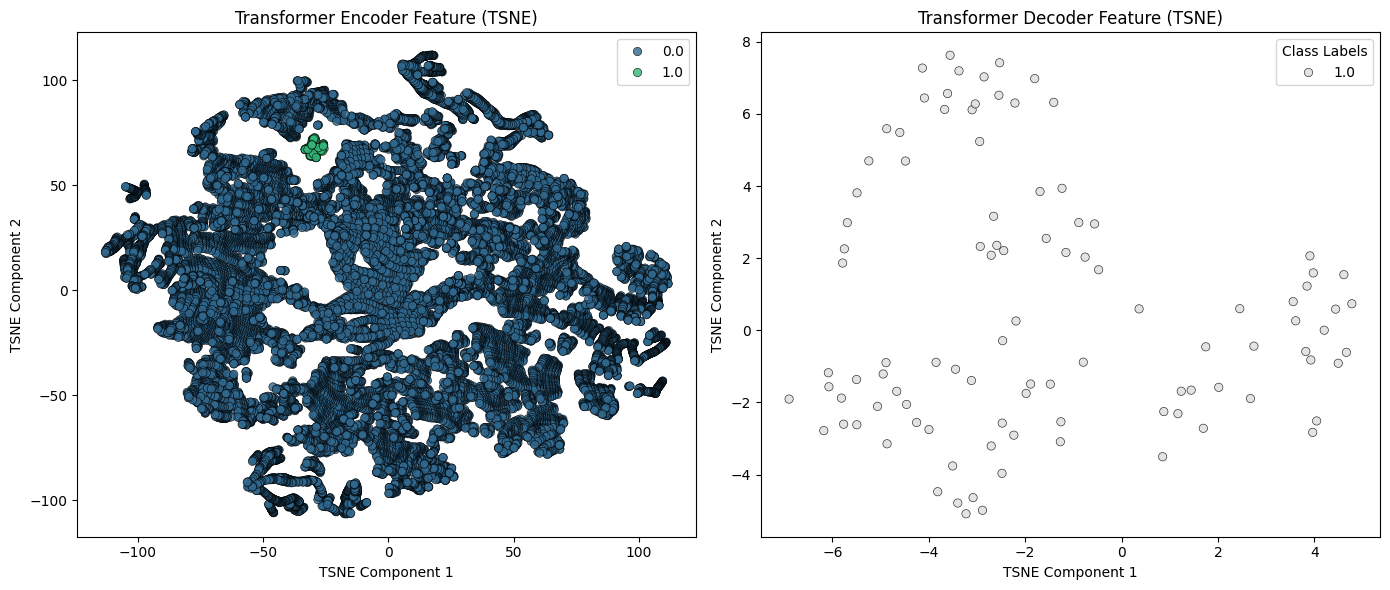

In [89]:
X = encoder_feature[0]
X2 = decoder_feature[0]
y = np.zeros((encoder_feature[0].shape[0], ), dtype=np.float32)
y2 = np.ones((decoder_feature[0].shape[0], ), dtype=np.float32)

a = np.concatenate([X, X2], axis=0)
b = np.concatenate([y, y2], axis=0)


#t-SNE 시각화
visualize_features(a, X2, b, y2, method="tsne")

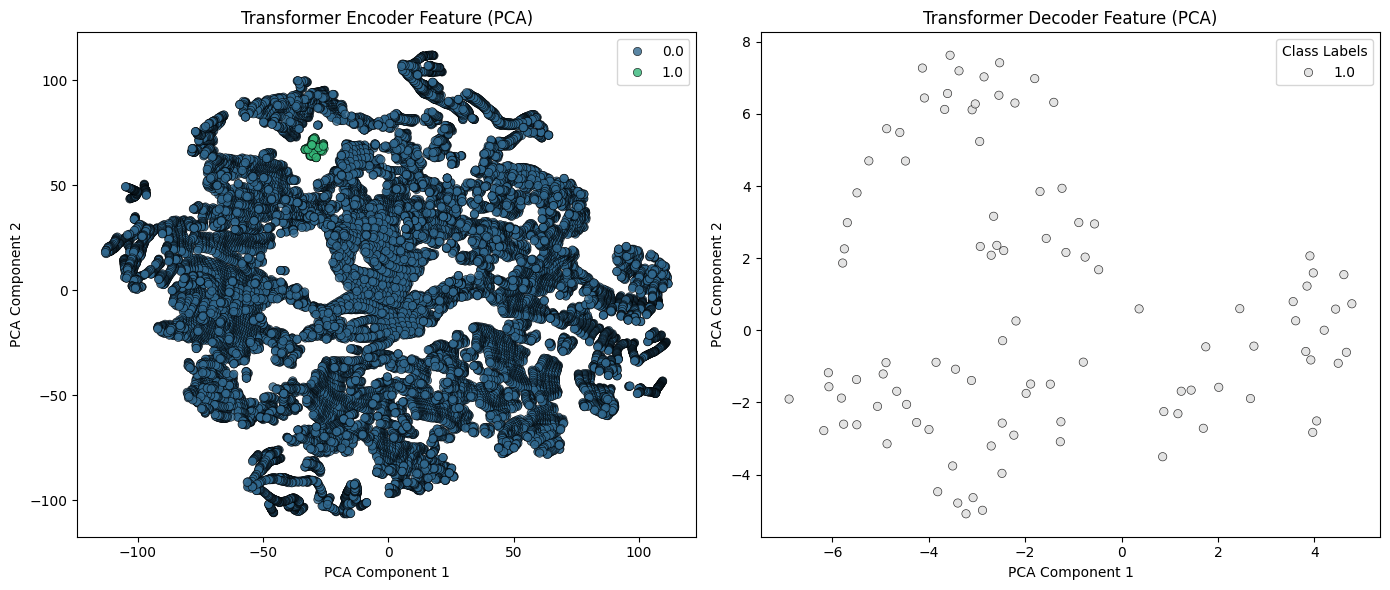

In [90]:
X = encoder_feature[0]
X2 = decoder_feature[0]
y = np.zeros((encoder_feature[0].shape[0], ), dtype=np.float32)
y2 = np.ones((decoder_feature[0].shape[0], ), dtype=np.float32)

a = np.concatenate([X, X2], axis=0)
b = np.concatenate([y, y2], axis=0)


#PCA 시각화
visualize_features(a, X2, b, y2, method="PCA")